## Data Exploration
Now that we have the data, let's load it up and take a look.

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import pandas as pd
print(f'Pandas {pd.__version__}')

Pandas 1.4.3


The competition recommends including external data sources and provides some 'starter' US census data in 'census_starter.csv'. But. I think we should start with just the training data and use it to set a baseline score that we can then try and improve upon by adding more data.

In [2]:
training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [3]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


Here are the column descriptions from the Kaggle competition site:
+ **row_id** - An ID code for the row.
+ **cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
+ **county_name** - The written name of the county.
+ **state_name** - The name of the state.
+ **first_day_of_month** - The date of the first day of the month.
+ **microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
+ **active** - The raw count of microbusinesses in the county. Not provided for the test set.

As stated above, we are going to use *microbusiness_density* only to start and then build from there. The plan being to predict the future microbusiness density from the past microbusiness density for each location.

Let's take a closer look at the microbusiness density data.

In [4]:
training_df['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

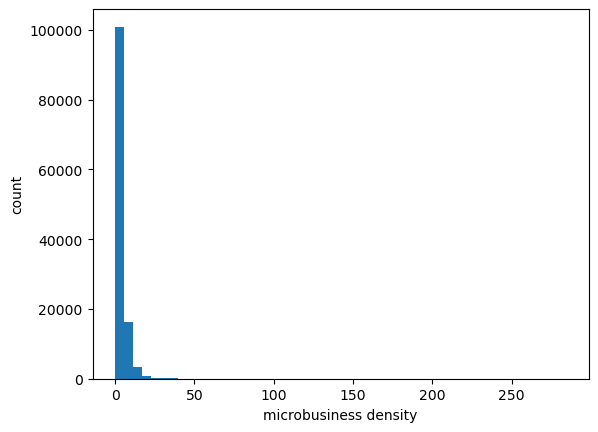

In [5]:
import matplotlib.pyplot as plt

plt.hist(training_df['microbusiness_density'], bins=50)
plt.xlabel('microbusiness density')
plt.ylabel('count')

plt.show()